#  Clustering & Network

**This notebook contains 2 parts of analysis**:
1. Cluster the result and identify overall high & low risk districts
2. Network of wards and further investigations

In [1]:
#Moduls import
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import logging
import seaborn as sns
import scipy.stats as stats
import plotly.express as px
import plotly.graph_objects as go
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import cdist

In [2]:
# Show last the outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last"
# Not show warning
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Plot settings
from matplotlib import rcParams
%matplotlib inline
rcParams['figure.figsize'] = 10, 8
sns.set_style('whitegrid')
sns.set(font_scale=1.5)

## Cluster the result and identify overall high & low risk districts
- Use K-means to culster 1-d risk levels for 76 wards
- Integrate geographical information with risk level to do clustering analysis

### Use K-means to culster 1-d risk levels for 76 wards

In [17]:
#read the data
results = pd.read_csv(r'D:/system_default/Desktop/summer intern/results.csv').drop('Unnamed: 0',axis=1)
#prepocessing
data = results.values 
scaler1 = preprocessing.StandardScaler()#Standardization
data=scaler1.fit_transform(data)
scaler2 = preprocessing.MinMaxScaler().fit(data)#Normalization
scaled_results = pd.DataFrame(scaler2.transform(data),columns=['original','200','150','time_re'])

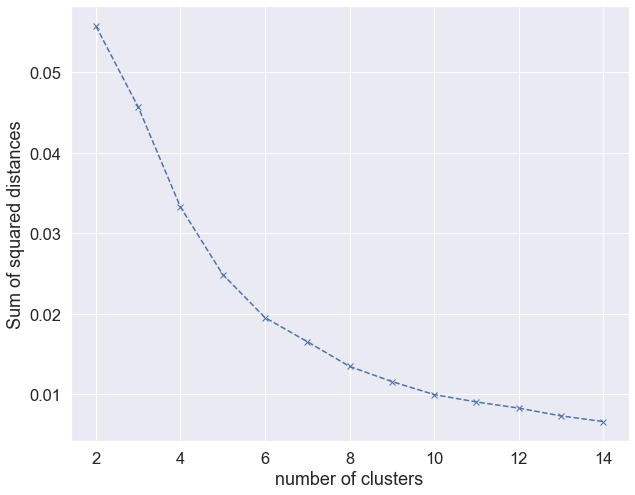

In [5]:
# Number of clusters needed using k-means without geographical information
K = range(2,15)#1D data,start with 2 clusters
mle=np.array(scaled_results['original']).reshape(-1,1)
meandistortions=[]
for k in K:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(mle)
    #Calculate mean distance of all points to their corresponding center
    meandistortions.append(sum(np.min(cdist(mle,kmeans.cluster_centers_,'euclidean'),axis=1))
                           /mle.shape[0])
#elbow chart
plt.plot(K,meandistortions,'bx--')
plt.xlabel('number of clusters')
plt.ylabel('Sum of squared distances')
plt.show()

In [6]:
#No obviously discernable "elbow", we choose 6 clusters
k_means = KMeans(init='k-means++',n_clusters=6,max_iter=500)
k_means.fit(mle)
label = k_means.fit_predict(mle)
print(k_means.cluster_centers_) 
results['label'] = label

[[0.        ]
 [0.70289555]
 [0.87871128]
 [0.61704993]
 [0.94898301]
 [0.79790554]]


<AxesSubplot:xlabel='index', ylabel='mle_original'>

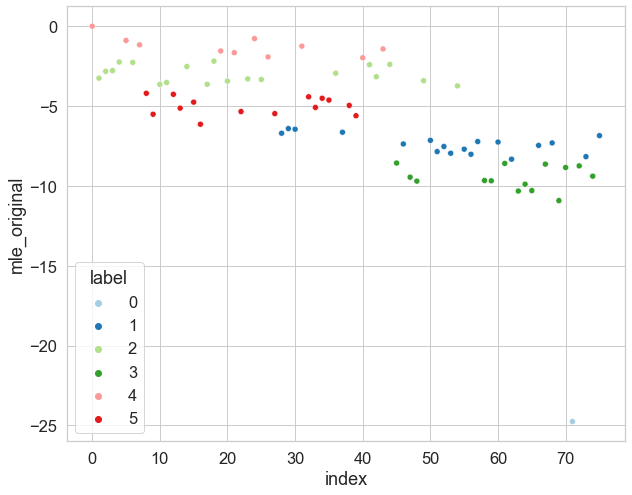

In [59]:
#visualize the results
r= results.reset_index()
sns.scatterplot(x='index', y='mle_original',data=r,hue="label" ,palette="Paired")

### Integrate geographical information with risk level to do clustering analysis

<font color=#483D8B>In this part of analysis, each ward will be allocated a representative point whose x and y coordinates will be regarded as 2 normal features. These 2 geographical features, along with the risk levels, will be inputted into various clustering models.  
    For each model, we start with finding appropriate parameters, e.g. number of clusters, and then fit the most suitable model to see what kind of findings can we get.   
    Here is the map for Nottinghamshire, we will use it to compare with our outputted clusters and see if they divide the area in similar manner.</font>

<img src="Nottingham.png" width="400">

In [18]:
#load data
ward =gpd.read_file(r'D:/system_default/Desktop/summer intern/nottinghamshire_wards.shp')
ward = ward.to_crs("EPSG:3857") #Conversion to a projection coordinate system
ward.head()

,NAME,AREA_CODE,DESCRIPTIO,FILE_NAME,NUMBER,NUMBER0,POLYGON_ID,UNIT_ID,CODE,HECTARES,AREA,TYPE_CODE,DESCRIPT0,TYPE_COD0,DESCRIPT1,geometry
0,Misterton (County ward),CED,County Electoral Division,NOTTINGHAMSHIRE_COUNTY,306.0,306.0,127816.0,42734.0,999999999,18880.677,43.566,VA,CIVIL VOTING AREA,None,None,"POLYGON ((-87581.319 7054399.548, -87603.643 7..."
1,Keyworth (County ward),CED,County Electoral Division,NOTTINGHAMSHIRE_COUNTY,307.0,307.0,127889.0,7896.0,999999999,7442.532,0.000,VA,CIVIL VOTING AREA,None,None,"POLYGON ((-115359.967 6949008.733, -115399.917..."
2,Bingham West (County ward),CED,County Electoral Division,NOTTINGHAMSHIRE_COUNTY,308.0,308.0,127893.0,44773.0,999999999,4841.584,0.000,VA,CIVIL VOTING AREA,None,None,"POLYGON ((-98571.760 6963156.625, -98590.524 6..."
3,Balderton (County ward),CED,County Electoral Division,NOTTINGHAMSHIRE_COUNTY,309.0,309.0,127869.0,7787.0,999999999,2609.473,0.000,VA,CIVIL VOTING AREA,None,None,"POLYGON ((-86638.198 6978726.463, -86665.143 6..."
4,Muskham & Farnsfield (County ward),CED,County Electoral Division,NOTTINGHAMSHIRE_COUNTY,310.0,310.0,127864.0,8095.0,999999999,16763.478,18.827,VA,CIVIL VOTING AREA,None,None,"POLYGON ((-89821.716 6999673.585, -89824.705 6..."


<AxesSubplot:>

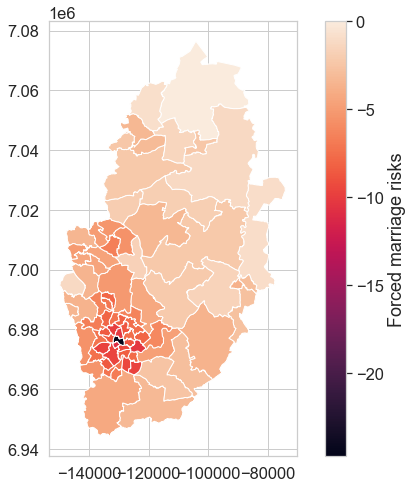

In [19]:
#Plot risk levels from Bradley terry model
ward['risk']=results['mle_original']
ward.plot(column='risk',legend =True,legend_kwds={'label': "Forced marriage risks"})

In [20]:
#kmeans clusters with 6 cluster centers
ward['clusters'] = label
clusters = ward[['clusters','geometry']].dissolve(by='clusters',as_index=False)
clusters.plot(column = 'clusters',legend = True,cmap="Spectral",legend_kwds={'label': "Kmeans without Geographical information"})

NameError: name 'label' is not defined

<AxesSubplot:>

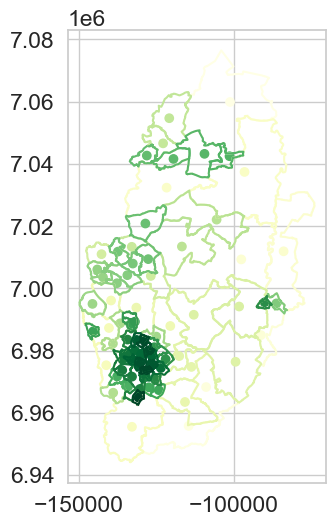

In [21]:
# Get the centre point (actually the centre of mass point)
X = np.array(ward.representative_point().x)
Y = np.array(ward.representative_point().y)
z = np.array(list(zip(X,Y)))
fig = plt.figure(figsize=(6,6),dpi=100)
ax = fig.add_subplot(1,1,1)
ward.boundary.plot(cmap='YlGn',ax=ax) 
ward.representative_point().plot(cmap='YlGn',ax=ax)

In [22]:
#Normalization & Standardizatiob
z = scaler1.fit_transform(np.column_stack((z,ward['risk'])))
z = scaler2.fit_transform(z)

<font color=#483D8B>Since we now have a 3-d dataset to cluster, we can expect that K-means cannot provide interesting results. That's because K-means can only give rigid boundaries, while the risk of forced marriage gradually diminishs from Nottinghamshire center to the periphery. 
We can still try K-means and see what it gives, but more informative results are those from **DBSCAN** and **GMM**.</font>

<AxesSubplot:>

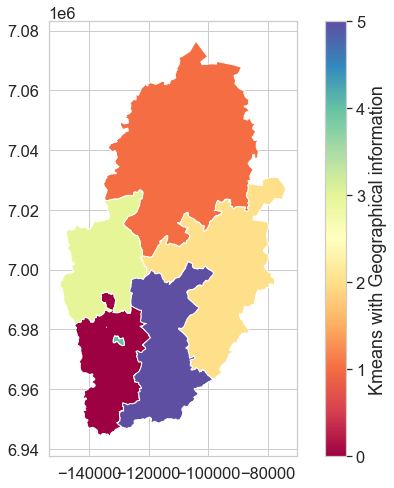

In [66]:
#Clustering using Kmeans
y_pred = KMeans(n_clusters=6, random_state=9).fit_predict(z)
ward['KMclusters'] = y_pred
clusters = ward[['KMclusters','geometry']].dissolve(by='KMclusters',as_index=False)
clusters.plot(column = 'KMclusters',legend = True,cmap="Spectral",legend_kwds={'label': "Kmeans with Geographical information"})

#### Density-based spatial clustering of applications with noise (DBSCAN)

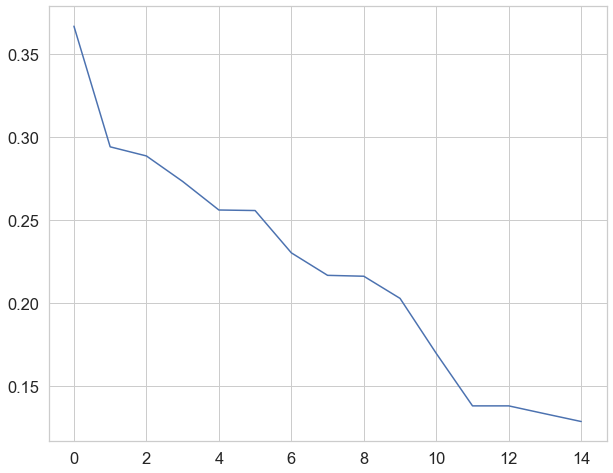

In [67]:
#Find suitable parameters
def select_MinPts(data,k):
    k_dist = []
    for i in range(15):
        dist = (((data[i] - data)**2).sum(axis=1)**0.5)
        dist.sort()
        k_dist.append(dist[k])
    return np.array(k_dist)
k = 5  #2*3 -1 
k_dist = select_MinPts(z,k)
k_dist.sort()
plt.plot(np.arange(k_dist.shape[0]),k_dist[::-1])
#No detectable elbow

In [69]:
#Find suitable parameters
res = []

for eps in np.arange(0.01,0.2,0.01):
    for min_samples in range(2,5):
        dbscan = DBSCAN(eps = eps, min_samples = min_samples)
        dbscan.fit(z)
        # Number of clusters(-1 is an outlier)
        n_clusters = len([i for i in set(dbscan.labels_) if i != -1])
        # Number of outliers
        outliners = np.sum(np.where(dbscan.labels_ == -1, 1,0))
        # Number of wars in on cluster
        stats = str(pd.Series([i for i in dbscan.labels_ if i != -1]).value_counts().values)
        res.append({'eps':eps,'min_samples':min_samples,'n_clusters':n_clusters,'outliners':outliners,'stats':stats})       
df = pd.DataFrame(res)

# We want say 5 clusters
df.loc[df.n_clusters == 5, :]

,eps,min_samples,n_clusters,outliners,stats
21,0.08,2,5,33,[31 5 3 2 2]
24,0.09,2,5,27,[32 11 2 2 2]
33,0.12,2,5,16,[49 4 3 2 2]
42,0.15,2,5,9,[54 5 3 3 2]


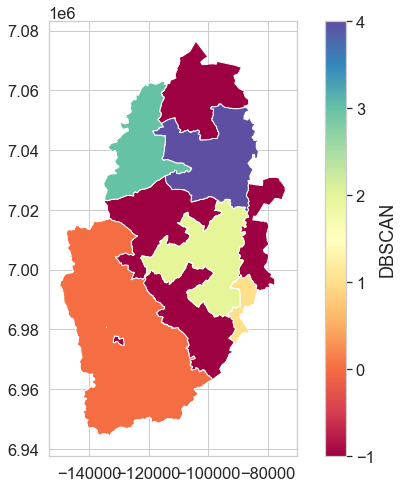

In [24]:
#Clustering using DBscan
y_pred = DBSCAN(eps = 0.15,min_samples=2).fit_predict(z)
ward['DBclusters'] = y_pred
clusters = ward[['DBclusters','geometry']].dissolve(by='DBclusters',as_index=False)
clusters.plot(column = 'DBclusters',legend = True,cmap="Spectral",legend_kwds={'label': "DBSCAN"})
plt.savefig("DBSCAN.png")

<font color=#483D8B>The wards with label **-1** are the outliers that do not belong to any clusters, which means they are different from their neighbors. One discernable pattern here is that except the extremely high risk ward in the center of the city of Nottingham, the southwestern part of the shire is clustered together. Basssetlaw is divided into 3 parts and the outliers' part has least risk of forced marriage.</font>

#### Distribution-based Gaussian Mixure Model (GMM)

Text(0.5, 0, 'n_components')

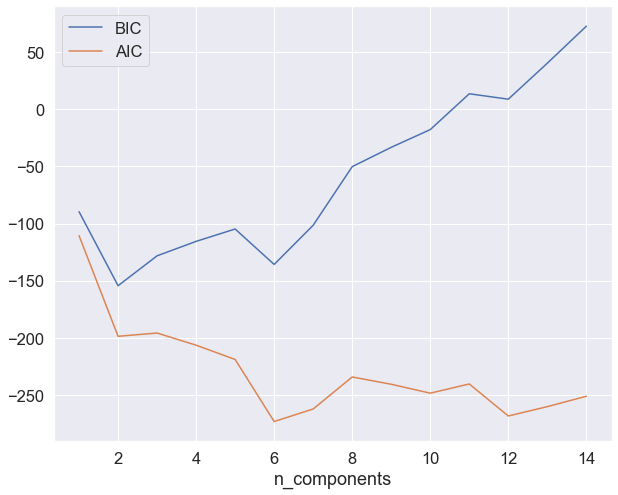

In [17]:
#How many clusters?
n_components = np.arange(1, 15)
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(z)
for n in n_components]
plt.plot(n_components, [m.bic(z) for m in models], label='BIC')
plt.plot(n_components, [m.aic(z) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components')
# BIC and AIC scores are low when the number of components is 6

In [10]:
gmm = GaussianMixture(6, covariance_type='full', random_state=0).fit(z)
labels = gmm.predict(z)

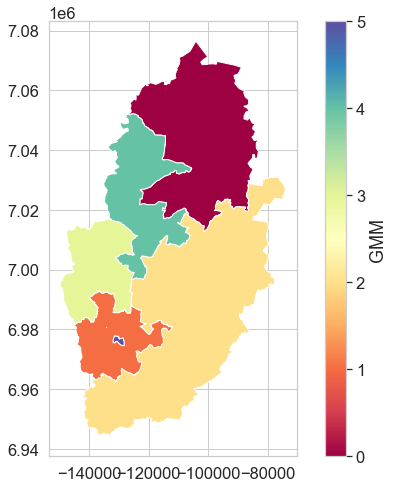

In [11]:
#Clustering using GMM
rcParams['figure.figsize'] = 10, 8
sns.set_style('whitegrid')
ward['GMclusters'] = labels
clusters = ward[['GMclusters','geometry']].dissolve(by='GMclusters',as_index=False)
clusters.plot(column = 'GMclusters',legend = True,cmap="Spectral",legend_kwds={'label': "GMM"})
plt.savefig("GMM.png")

<font color=#483D8B> This time, apart from its northwest corner, Newark and Sherwood is clustered with Rushcliffe into one area. The rest of wards are divided into 4 clusters leaving the highest risk 1 ward as a cluster. The boundaries of these 6 clusters are quite different from the ones on the map.</font>

<font color=#483D8B>All the distance measurements we use so far are Euclidean distances, which might be problematic since city centers are typically densely packed with small areas and the rural areas have more distantly distributed wards. That's the reason why we explore network properties and try to use network-based distance as clustering metric in the final section.</font>

## Network of wards and further investigations
- Construct a network for Nottinghamshire wards based on whether they border each other
- Investigate network properties for individual wards and their correlation with risk level
- Cluster using network information and risk level
- Replace Euclidean distance with a shortest path length based metric to cluster the wards

### Construct a network for Nottinghamshire wards based on whether they border each other

In [12]:
ward =gpd.read_file(r'D:/system_default/Desktop/summer intern/nottinghamshire_wards.shp')
ward['risk'] = np.abs(results['mle_original']) 
ward.head()

,NAME,AREA_CODE,DESCRIPTIO,FILE_NAME,NUMBER,NUMBER0,POLYGON_ID,UNIT_ID,CODE,HECTARES,AREA,TYPE_CODE,DESCRIPT0,TYPE_COD0,DESCRIPT1,geometry,risk
0,Misterton (County ward),CED,County Electoral Division,NOTTINGHAMSHIRE_COUNTY,306.0,306.0,127816.0,42734.0,999999999,18880.677,43.566,VA,CIVIL VOTING AREA,None,None,"POLYGON ((480794.500 388179.104, 480781.704 38...",0.000000
1,Keyworth (County ward),CED,County Electoral Division,NOTTINGHAMSHIRE_COUNTY,307.0,307.0,127889.0,7896.0,999999999,7442.532,0.000,VA,CIVIL VOTING AREA,None,None,"POLYGON ((465047.604 324692.297, 465023.297 32...",3.252397
2,Bingham West (County ward),CED,County Electoral Division,NOTTINGHAMSHIRE_COUNTY,308.0,308.0,127893.0,44773.0,999999999,4841.584,0.000,VA,CIVIL VOTING AREA,None,None,"POLYGON ((475079.098 333375.901, 475067.901 33...",2.826880
3,Balderton (County ward),CED,County Electoral Division,NOTTINGHAMSHIRE_COUNTY,309.0,309.0,127869.0,7787.0,999999999,2609.473,0.000,VA,CIVIL VOTING AREA,None,None,"POLYGON ((482131.502 342870.504, 482115.598 34...",2.783727
4,Muskham & Farnsfield (County ward),CED,County Electoral Division,NOTTINGHAMSHIRE_COUNTY,310.0,310.0,127864.0,8095.0,999999999,16763.478,18.827,VA,CIVIL VOTING AREA,None,None,"POLYGON ((480001.902 355425.600, 480000.096 35...",2.243959


In [13]:
# Get adjacent wards
connections = []
for i in range(len(ward)-1):
    for j in range(i+1,len(ward)):
        if ward['geometry'][i].touches(ward['geometry'][j])==True:
            connections.append((i,j))
connections[0:5] # print first 5 connections

[(0, 7), (0, 24), (0, 43), (0, 44), (1, 2)]

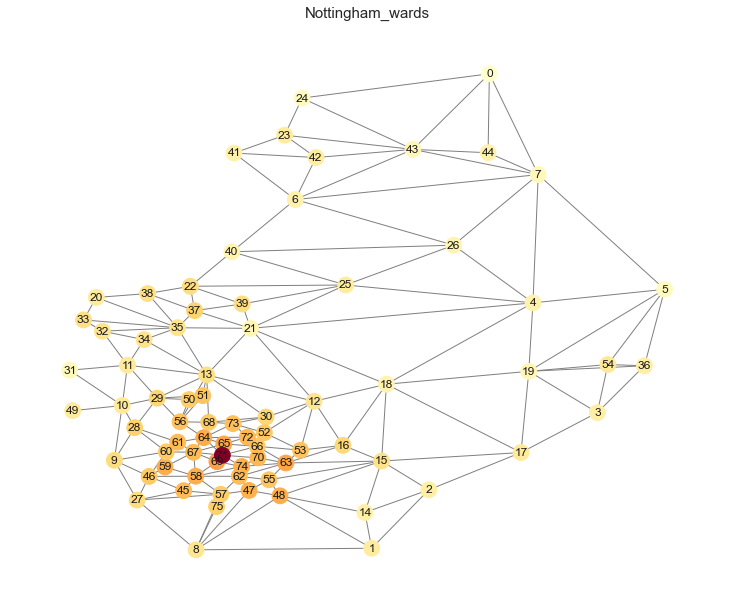

In [14]:
import networkx as nx
import pylab 

# Get the centre point (actually the centre of mass point)
X = np.array(ward.representative_point().x)
Y = np.array(ward.representative_point().y)
z = list(zip(X,Y))

#vidualise the network
g = nx.Graph()
g.add_edges_from(connections)

dic,p = dict(),dict()
for i in range(0,76):
    dic[i],p[i] = z[i],ward['risk'][i]
position = dic

nx.draw(g,pos=position,nodelist=list(p.keys()),node_size=250,with_labels = True,node_color=list(p.values()),edge_color='grey',cmap=plt.cm.YlOrRd)
pylab.title('Nottingham_wards',fontsize=15)
plt.savefig("Network.png")
pylab.show()
# colored according to FM risks

### Investigate network properties for individual wards and their correlation with risk level

In [24]:
# Show all the outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [25]:
A = nx.adjacency_matrix(g)
print(A.todense())

#degree distribution
g.degree()
nx.degree_histogram(g)

#clustering coefficient
# how closely nodes in a network tend to group or “cluster” together.
cc = nx.clustering(g)

#Betweenness
#the sum of the fraction of all-pairs shortest paths that pass through the node
Between = nx.betweenness_centrality(g,normalized = True)

#Centrality and Communicability based on matrix exponential
com = nx.communicability_exp(g)
cen,deg,bet,clu = [],[],[],[]
for i in range(76):
    cen.append(com[i][i])
    deg.append(g.degree()[i])
    bet.append(Between[i])
    clu.append(cc[i])

[[0 1 1 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 1 1 0]]


DegreeView({0: 4, 7: 7, 24: 3, 43: 7, 44: 3, 1: 4, 2: 4, 8: 6, 14: 4, 48: 6, 15: 8, 17: 5, 3: 4, 19: 7, 36: 4, 54: 4, 4: 7, 5: 5, 18: 7, 21: 8, 25: 6, 26: 5, 6: 6, 40: 4, 41: 3, 42: 4, 27: 5, 47: 5, 57: 7, 75: 2, 9: 5, 10: 6, 28: 5, 46: 6, 60: 6, 11: 6, 29: 7, 31: 2, 49: 1, 13: 10, 32: 4, 34: 4, 12: 7, 16: 5, 30: 5, 52: 6, 53: 5, 35: 8, 51: 4, 56: 6, 68: 5, 55: 5, 63: 8, 20: 3, 33: 3, 38: 4, 37: 5, 39: 4, 22: 5, 23: 4, 45: 4, 61: 4, 50: 3, 73: 5, 58: 8, 59: 4, 62: 6, 66: 7, 72: 5, 64: 8, 67: 8, 69: 4, 74: 6, 70: 4, 65: 5, 71: 7})

[0, 1, 2, 6, 20, 17, 12, 10, 7, 0, 1]

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

centrality    13
dtype: int64

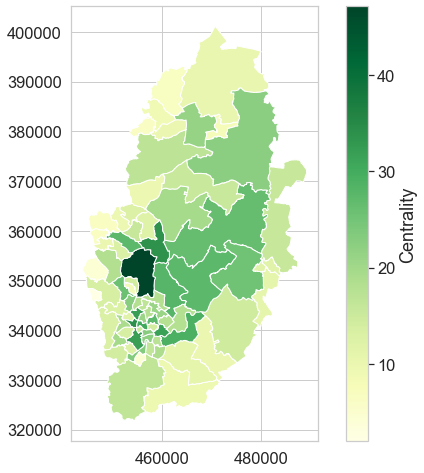

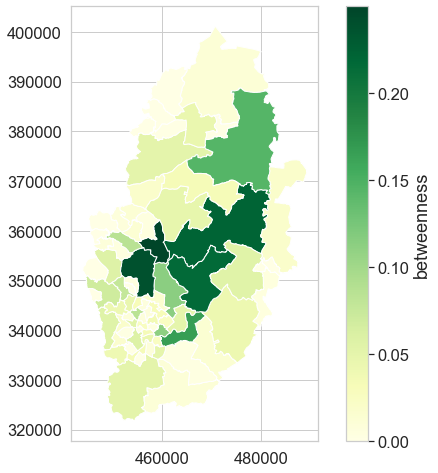

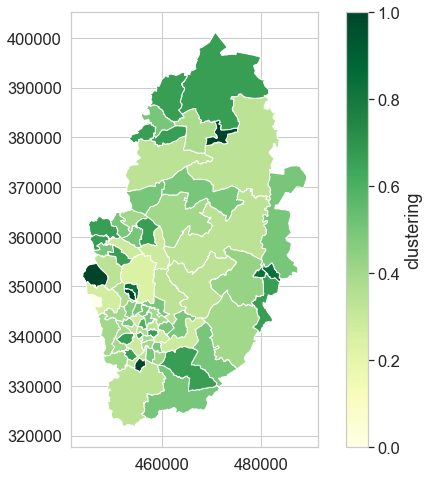

In [26]:
# Plot Centrality, Betweenness and clustering coefficients on the map
ward['centrality'] = cen
ward['degree'] = deg
ward['betweenness'] = bet
ward['clustering'] = clu
ax = fig.add_subplot(3,1,1)
ward.plot(column='centrality',legend =True,legend_kwds={'label': "Centrality"},cmap='YlGn') 
ax = fig.add_subplot(3,1,2)
ward.plot(column='betweenness',legend =True,legend_kwds={'label': "betweenness"},cmap='YlGn') 
ax = fig.add_subplot(3,1,3)
ward.plot(column='clustering',legend =True,legend_kwds={'label': "clustering"},cmap='YlGn') 
ward[['centrality']].idxmax()

<font color=#483D8B>Centrality quantifies each node's "well-connectedness", Betweenness shows how the overall communicability changes when the node is removed, and the Clustering coefficient measures the degree to which nodes in a graph tend to cluster together. From the above 3 diagrams, though the clustering coefficients don't have any obvious pattern, the central band of the Nottinghamshire have high centrality and betweenness. We can also notice that these properties show little similarity with the risk levels whose values decrease from the city center to the suburb. </font>

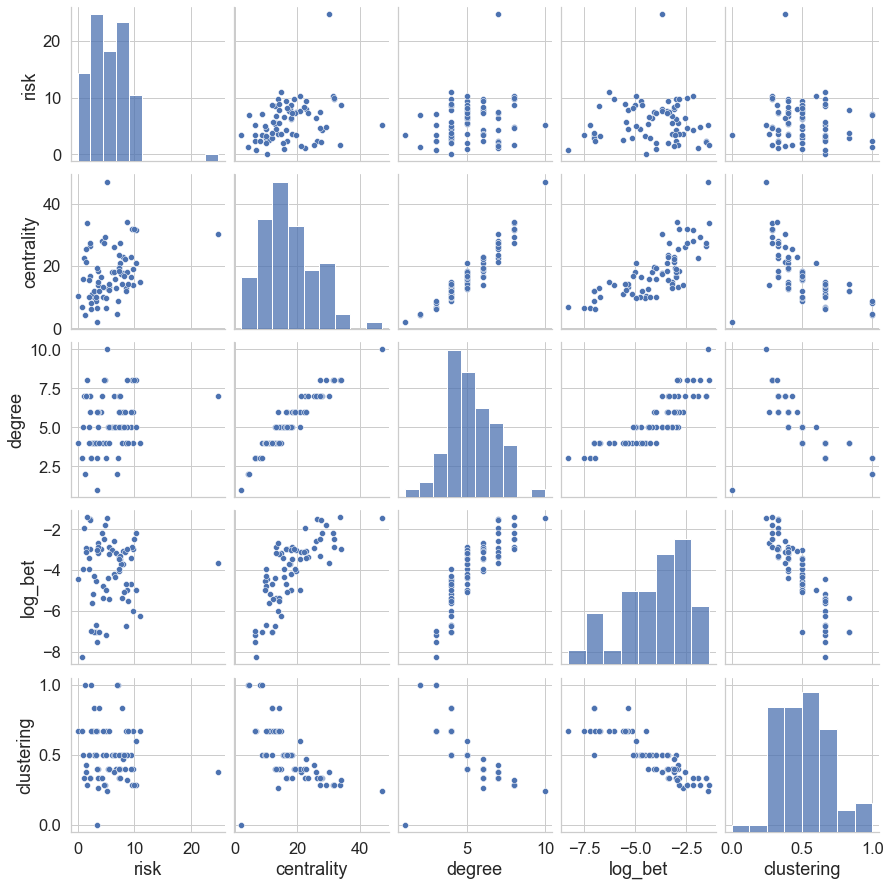

In [27]:
ward['log_bet'] = np.log(ward['betweenness'])
sns.pairplot(ward[['risk','centrality','degree','log_bet','clustering']],palette='hls')
#Note: Absolute value of risks (higher worser) & log scale of betweenness

<AxesSubplot:>

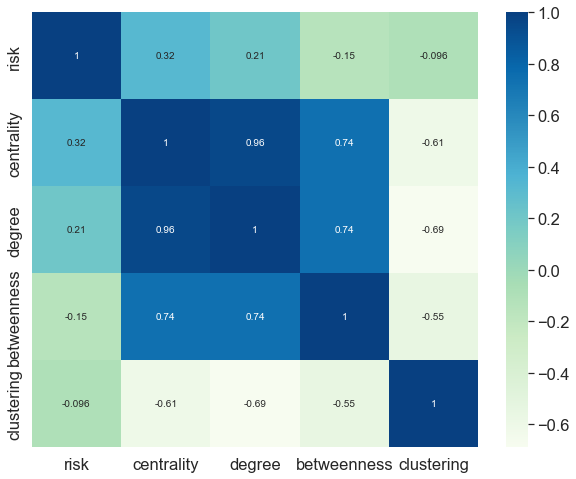

In [28]:
corr = ward[['risk','centrality','degree','betweenness','clustering']].corr()
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns,annot = True,cmap="GnBu")


<font color=#483D8B>From the pairwise scatterplot and the correlations between the network properties and the forced marriage risk, we can confirm our observation that risk levels show insignificant associations with the network properties. Additionally, since it is found that the correlations between individual network measurements are relatively high, it is necessary to do dimensionality reduction before clustering network information and risk levels.</font>

### Cluster using network information and risk level

In [29]:
#prepocessing
data = ward[['risk','centrality','degree','betweenness','clustering']].values 
scaler1 = preprocessing.StandardScaler()#Standardization
data=scaler1.fit_transform(data)
scaler2 = preprocessing.MinMaxScaler().fit(data)#Normalization
scaled_data = pd.DataFrame(scaler2.transform(data),columns=['risk','centrality','degree','betweenness','clustering'])

In [30]:
# Test for whether suitable for PCA or not
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
 
chi_square_value, p_value = calculate_bartlett_sphericity(scaled_data[['centrality','degree','betweenness']])
print(chi_square_value, p_value) 

241.7249613608871 4.031605339187994e-52


In [31]:
#Principle Component Analysis；condense network information to less variable (Reduce Noise and easier to visualize)
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(scaled_data[['centrality','degree','betweenness','clustering']].values )

pca.explained_variance_ratio_ #Bigger that 90%

array([0.78271268, 0.12323701])

In [32]:
# Show last the outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last"

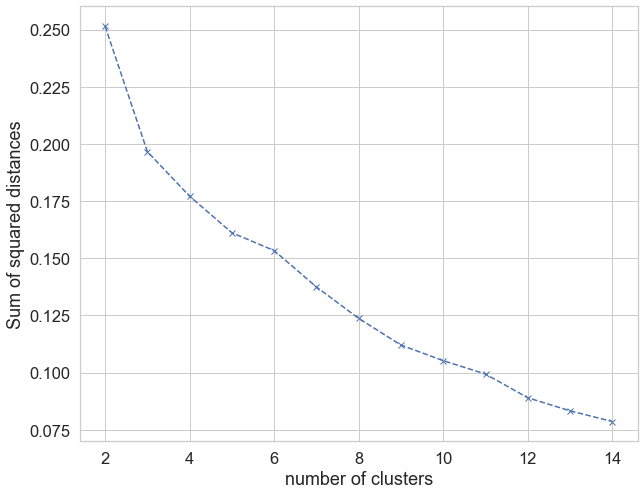

In [33]:
#Number of clusters
from sklearn.cluster import KMeans
#K-means
dimension_reduced_data = pd.DataFrame(X_pca,columns = ['pca1','pca2'])
dimension_reduced_data['risk'] = scaled_data['risk']

K = range(2,15)
meandistortions=[]
for k in K:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(dimension_reduced_data[['pca1','pca2','risk']].values)
    #Calculate mean distance of all points to their corresponding center
    meandistortions.append(sum(np.min(cdist(dimension_reduced_data,kmeans.cluster_centers_,'euclidean'),axis=1))
                           /dimension_reduced_data.shape[0])
#elbow chart
plt.plot(K,meandistortions,'bx--')
plt.xlabel('number of clusters')
plt.ylabel('Sum of squared distances')
plt.show()

<AxesSubplot:>

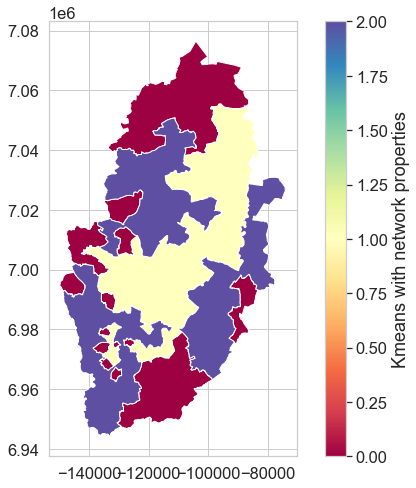

In [77]:
#3 clusters
k_means = KMeans(init='k-means++',n_clusters=3,max_iter=500)
k_means.fit(dimension_reduced_data[['pca1','pca2','risk']].values)
label = k_means.fit_predict(dimension_reduced_data[['pca1','pca2','risk']].values)
#kmeans clusters with 6 cluster centers
ward['clusters'] = label
clusters = ward[['clusters','geometry']].dissolve(by='clusters',as_index=False)
clusters.plot(column = 'clusters',legend = True,cmap="Spectral",legend_kwds={'label': "Kmeans with network properties"})

<font color=#483D8B>It is hard to find overlapped part between the block division and these 3 clusters, which is not surprising because the distribution of network properties is neither similar to the original block division nor highly correlated with the level of forced marriage risk.</font>

### Replace Euclidean distance with a shortest path length based metric to cluster the wards

<font color=#483D8B>In this section, we define a new distance metric using the shortest path length between 2 wards. The following graph shows how the distance is calculated where the absolute difference of 2 wards' risk is normalized and the path length is divided by the diameter of the network.  
***my_distance(a,b)*** function defines the metric and we use both Kmeans and DBSCAN to see what results will be given.</font>

<img src="distance.jpg" width="400">

[-0.5, 0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5]


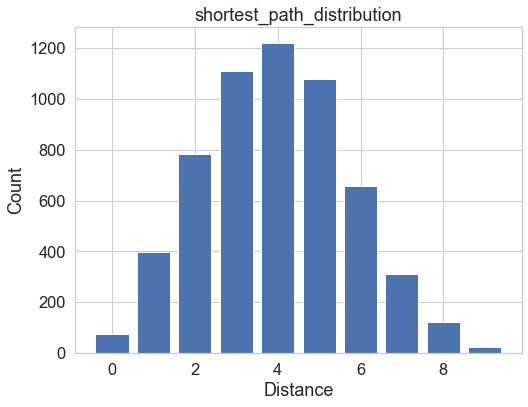

In [35]:
#Distribution of path length
def path_length_histogram(G, title=None):
    # Find path lengths
    length_source_target = dict(nx.shortest_path_length(G))
    # Convert dict of dicts to flat list
    all_shortest = sum([
        list(length_target.values())
        for length_target
        in length_source_target.values()],
    [])
    # Calculate integer bins
    high = max(all_shortest)
    
    bins = [-0.5 + i for i in range(high + 2)]
    print(bins)
    # Plot histogram
    plt.hist(all_shortest, bins=bins, rwidth=0.8)
    plt.title(title)
    plt.xlabel("Distance")
    plt.ylabel("Count")

    
plt.figure(figsize=(8,6))

path_length_histogram(g,title='shortest_path_distribution')

In [36]:
# input 2 np.array in the form (ward number, risk level)
# output distance based on shortest path between this 2 wards (float)
# need to round the outputs from each iteration in clustering to make sure distance can be found
def my_distance(a,b):
    pathlength = nx.shortest_path_length(g, source=np.round(a[0]), target=np.round(b[0]))/nx.diameter(g)
    distance = np.sqrt(pathlength**2 + (a[1]-b[1])**2)
    return distance

In [88]:
data = pd.DataFrame(np.arange(76),columns = ['ward'])
data['risk'] = scaled_data['risk']
data.head() #data to be clustered

,ward,risk
0,0,0.000000
1,1,0.131392
2,2,0.114202
3,3,0.112459
4,4,0.090653


In [38]:
#DBSCAN
#Find suitable parameters
res = []

for eps in np.arange(0.01,0.2,0.01):
    for min_samples in range(2,5):
        dbscan = DBSCAN(eps = eps, min_samples = min_samples, metric=lambda a, b: my_distance(a, b))
        dbscan.fit(data.values)
        # Number of clusters(-1 is an outlier)
        n_clusters = len([i for i in set(dbscan.labels_) if i != -1])
        # Number of outliers
        outliners = np.sum(np.where(dbscan.labels_ == -1, 1,0))
        # Number of wars in on cluster
        stats = str(pd.Series([i for i in dbscan.labels_ if i != -1]).value_counts().values)
        res.append({'eps':eps,'min_samples':min_samples,'n_clusters':n_clusters,'outliners':outliners,'stats':stats})       
df = pd.DataFrame(res)

# We want say 5 clusters
df.loc[df.n_clusters == 5, :]

,eps,min_samples,n_clusters,outliners,stats
34,0.12,3,5,11,[17 14 13 12 9]
35,0.12,4,5,20,[16 11 11 9 9]


In [39]:
y_pred = DBSCAN(eps = 0.12,min_samples=3,metric=lambda a, b: my_distance(a, b)).fit_predict(data.values)

<AxesSubplot:>

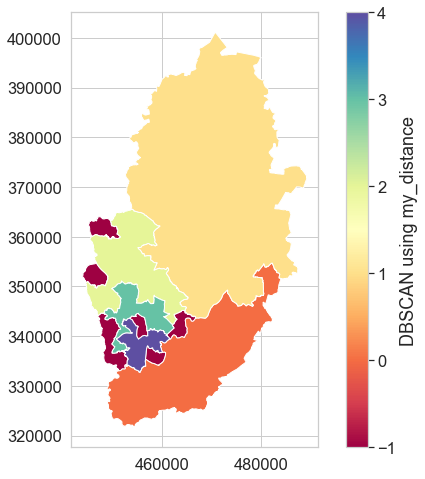

In [40]:
ward['clusters'] = y_pred
clusters = ward[['clusters','geometry']].dissolve(by='clusters',as_index=False)
clusters.plot(column = 'clusters',legend = True,cmap="Spectral",legend_kwds={'label': "DBSCAN using my_distance"})

<font color=#483D8B>This clustering gave relatively good results, with Rushcliff being almost perfectly partitioned and most of the regions of Newark and Sherwood being grouped into one cluster with Bassetlaw. </font>

In [41]:
# Kmeans
from pyclustering.utils.metric import distance_metric, type_metric
from pyclustering.cluster.kmeans import kmeans, kmeans_visualizer
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer
from pyclustering.samples.definitions import FCPS_SAMPLES
from pyclustering.utils import read_sample

In [101]:
sample = data.values
#Prepare initial centers using K-Means++ method.
initial_centers = kmeans_plusplus_initializer(sample,amount_centers = 6,random_state = 5).initialize()
my_metric = distance_metric(type_metric.USER_DEFINED, func=my_distance)

#create instance of K-Means using specific distance metric:
kmeans_instance = kmeans(sample, initial_centers, metric=my_metric)

#Run cluster analysis and obtain results.
kmeans_instance.process()
clusters = kmeans_instance.get_clusters()
final_centers = kmeans_instance.get_centers()

<AxesSubplot:>

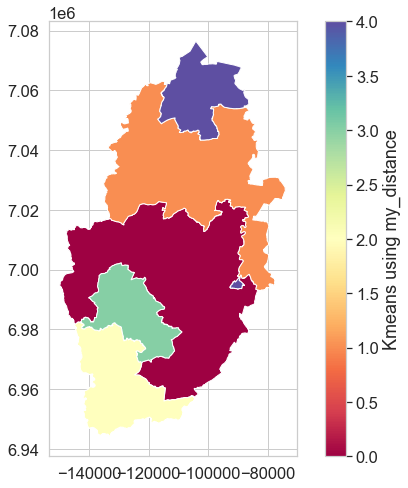

In [102]:
for i in range(len(clusters)):
    ward.loc[clusters[i],'kkmeans'] = i
clusters = ward[['kkmeans','geometry']].dissolve(by='kkmeans',as_index=False)
clusters.plot(column = 'kkmeans',legend = True,cmap="Spectral",legend_kwds={'label': "Kmeans using my_distance"})

<font color=#483D8B> </font>

### Summary

**The following conclusions can be made**:
1. Different models with different parameters can give distinct clusters, and some of the boundaries of the clusters have some overlapping with the ones in the map.
2. Network properties of the wards in Nottinghamshire insignificantly correlate with the forced marriage risks that gradually decrease from the city centre to the peripheral areas.
**Further investigations on the following aspects may be helpful**:
1. Further fine-tune the parameters in the clustering algorithms and see what will be changed.
2. Instead of simply round the iterative ward number from clustering algorithms to secure the shortest path can be found, a more accurate way of allocating wards with decimals to the ones in the network is needed.